In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import seam_carving
import cv2
from skimage import io, transform, color
import pandas as pd
import seaborn as sns
# Read the CSV file from specifix path in external CD
breast_level_annotations = pd.read_csv('E:/PhD/V_M_Dataset/breast-level_annotations.csv')
# Read the CSV file
finding_annotations = pd.read_csv('E:/PhD/V_M_Dataset/finding_annotations.csv')
metadata = pd.read_csv('E:/PhD/V_M_Dataset/metadata.csv')
#for our interes we create the new DB with important columns in owr interes.
selected_columns_BLA = breast_level_annotations[[ 'study_id' , 'series_id', 'image_id', 'breast_birads', 'split','laterality' , 'view_position', 'breast_density']]


selected_columns_BLA.head()

,study_id,series_id,image_id,breast_birads,split,laterality,view_position,breast_density
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,BI-RADS 2,training,L,CC,DENSITY C
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,BI-RADS 2,training,L,MLO,DENSITY C
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,BI-RADS 2,training,R,CC,DENSITY C
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,BI-RADS 2,training,R,MLO,DENSITY C
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,BI-RADS 1,training,L,CC,DENSITY C


In [3]:
import os
from matplotlib import pyplot as plt

In [4]:
from numba import njit
#from numba we import njit to decreace the time cost(numba library ofert this)
@njit
def energy(I):
    L, C = I.shape  # Assuming the third dimension represents the channels
    E = np.zeros((L, C), dtype=np.int64)

    for l in range(L):
        for c in range(C):
            g = I[l, c]  # Assuming grayscale, taking the first channel
            Rsize = 0  # real size of the neighborhood.

            # Llogarit energjinë bazuar në dallimet me pikselët fqinj
            if inImage(l, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l, c + 1])  # Lindje (E)
            if inImage(l + 1, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c + 1])  # NE
            if inImage(l + 1, c, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c])  # N
            if inImage(l + 1, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l + 1, c - 1])  # NW
            if inImage(l, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l, c - 1])  # Perëndim (W)
            if inImage(l - 1, c - 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c - 1])  # SW
            if inImage(l - 1, c, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c])  # S
            if inImage(l - 1, c + 1, L, C):
                Rsize += 1
                E[l, c] += abs(g - I[l - 1, c + 1])  # SE

            # Normalizo energjitë në proporcion 8/Rsize.
            # Madhësia e fqinjëve për pikat në qoshet është 3 ==> energjia shtohet me 8/3.
            # Madhësia e fqinjëve për pikat në kufir është 5 ==> energjia shtohet me 8/5.
            # Madhësia e fqinjëve për pikat brenda është 8 ==> energjia nuk ndryshon.
            E[l, c] = round(E[l, c] * 8/ Rsize)
    E = np.abs(E)
    return E
from numba import jit
# Funksioni ndihmës për të kontrolluar nëse një piksel është brenda kufijve të imazhit
@jit(nopython=True)
def inImage(row, col, numRows, numCols):
    return 0 <= row < numRows and 0 <= col < numCols


In [6]:
from skimage.measure import shannon_entropy
# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/V_M_Dataset/images/'):
    for i in range(len(data)):
        image_id = data.iloc[i, 0]  # Merre ID-në e imazhit nga kolona e parë
        image_folder = data.iloc[i, 0]  # Marrim emrin e folderit ku ndodhet imazhi
        image_name = data.iloc[i, 2]  # Merre emrin e imazhit nga kolona e tretë (nëse është ndryshe, ndryshoje këtu)
        
        # Ndërtimi i path-it të plotë për imazhin
        image_path = os.path.join(base_path, image_folder, f'{image_name}.dicom.jpg')
        
        # Kontrollo nëse ekziston file-i
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(energy_im)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

filloj grupi me i madhe
mbaroj grupi me i madhe
mbaroj grupi br2
mbaroj grupi br3
mbaroj grupi br4


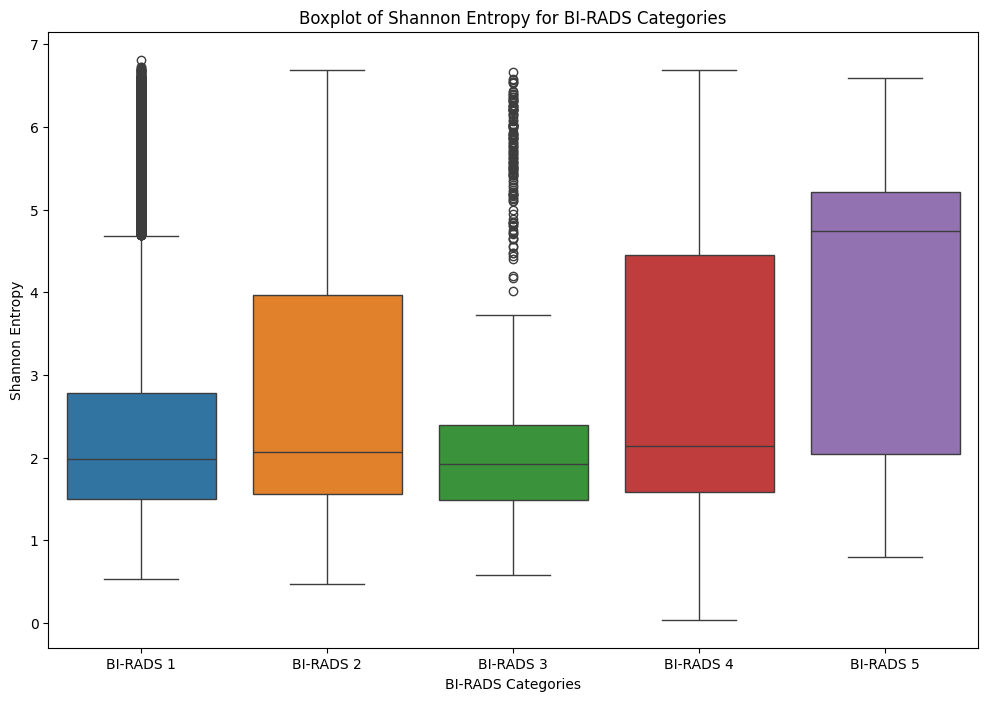

In [7]:
selected_columns_BLA_br1 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 1']
selected_columns_BLA_br2 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 2']
selected_columns_BLA_br3 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 3']
selected_columns_BLA_br4 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 4']
selected_columns_BLA_br5 = selected_columns_BLA.loc[selected_columns_BLA['breast_birads'] == 'BI-RADS 5']
# Ndarja e klasave BI-RADS nga grupi selected_columns_BLA
selected_columns_BLA_br1_entropy = []
selected_columns_BLA_br2_entropy = []
selected_columns_BLA_br3_entropy = []
selected_columns_BLA_br4_entropy = []
selected_columns_BLA_br5_entropy = []

# Llogarit entropinë për secilën klasë BI-RADS
selected_columns_BLA_br1_1 = selected_columns_BLA_br1.iloc[:1000 , :]
print('filloj grupi me i madhe')
calculate_entropy(selected_columns_BLA_br1, selected_columns_BLA_br1_entropy)
print('mbaroj grupi me i madhe')
calculate_entropy(selected_columns_BLA_br2, selected_columns_BLA_br2_entropy)
print('mbaroj grupi br2')
calculate_entropy(selected_columns_BLA_br3, selected_columns_BLA_br3_entropy)
print('mbaroj grupi br3')
calculate_entropy(selected_columns_BLA_br4, selected_columns_BLA_br4_entropy)
print('mbaroj grupi br4')
calculate_entropy(selected_columns_BLA_br5, selected_columns_BLA_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': selected_columns_BLA_br1_entropy,
    'BI-RADS 2': selected_columns_BLA_br2_entropy,
    'BI-RADS 3': selected_columns_BLA_br3_entropy,
    'BI-RADS 4': selected_columns_BLA_br4_entropy,
    'BI-RADS 5': selected_columns_BLA_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()


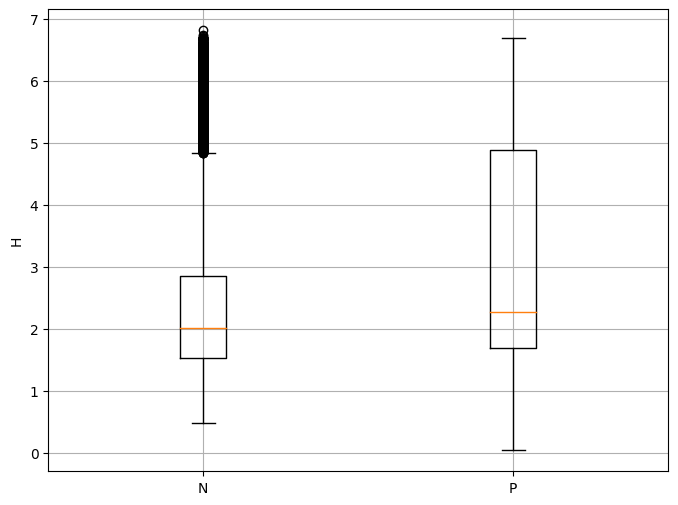

P-Value: 6.867643094786371e-12
Ka një ndryshim domethënës midis dy grupeve.


In [13]:
from scipy.stats import mannwhitneyu
# Krijimi i dy grupeve të bashkuara
entropy_classe_normal = np.concatenate([
    selected_columns_BLA_br1_entropy, 
    selected_columns_BLA_br2_entropy, 
    selected_columns_BLA_br3_entropy
])

entropy_classe_malignant = np.concatenate([
    selected_columns_BLA_br4_entropy, 
    selected_columns_BLA_br5_entropy
])

# Boxplot për krahasim
plt.figure(figsize=(8, 6))
plt.boxplot([entropy_classe_normal, entropy_classe_malignant], labels=['N', 'P'])
plt.ylabel("H")
plt.grid(True)
plt.show()

# Llogaritja e p-value me Mann-Whitney U test (jo-parametrik)
stat, p_value = mannwhitneyu(entropy_classe_normal, entropy_classe_malignant, alternative='two-sided')

print(f"P-Value: {p_value}")

# Interpretimi
if p_value < 0.05:
    print("Ka një ndryshim domethënës midis dy grupeve.")
else:
    print("Nuk ka një ndryshim domethënës midis dy grupeve.")

### Saudi arabia dataset

In [9]:
# Saudi arabia dataset
Saudi_Arabias_data = pd.read_csv(r"E:\PhD\Saudi_Arabia\mammograms\filtered_BIRAD_2_and_causes_without_4images.csv")

print(f'In chinese database we have  {len(Saudi_Arabias_data)}  records')
Saudi_Arabias_data.head(2)

Saudi_Arabias_data_br1 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 1']
Saudi_Arabias_data_br2 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 2']
Saudi_Arabias_data_br3 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 3']
Saudi_Arabias_data_br4 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 4']
Saudi_Arabias_data_br5 =Saudi_Arabias_data.loc[Saudi_Arabias_data['Assesment'] == 'BIRAD 5']



In chinese database we have  1344  records


In [10]:

# Llogaritja e entropisë për secilën klasë BI-RADS
def calculate_entropy(data, entropy_list, base_path='E:/PhD/Saudi_Arabia/'):
    for i in range(len(data)):
        file_path = Saudi_Arabias_data.iloc[i, 7].replace('.dcm', '.jpg')
        # Construct the full image path
        image_path = os.path.join(base_path, file_path)
        #image = cv2.imread(image_path)
        # Kontrollo nëse ekziston file-i
        print(i)
        if os.path.exists(image_path):
            # Leximi i imazhit
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            energy_im = energy(image.astype(int))
            
            # Llogaritja e entropisë
            entropy_value = shannon_entropy(energy_im)
            
            # Ruajtja e vlerës në listë
            entropy_list.append(entropy_value)

          

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

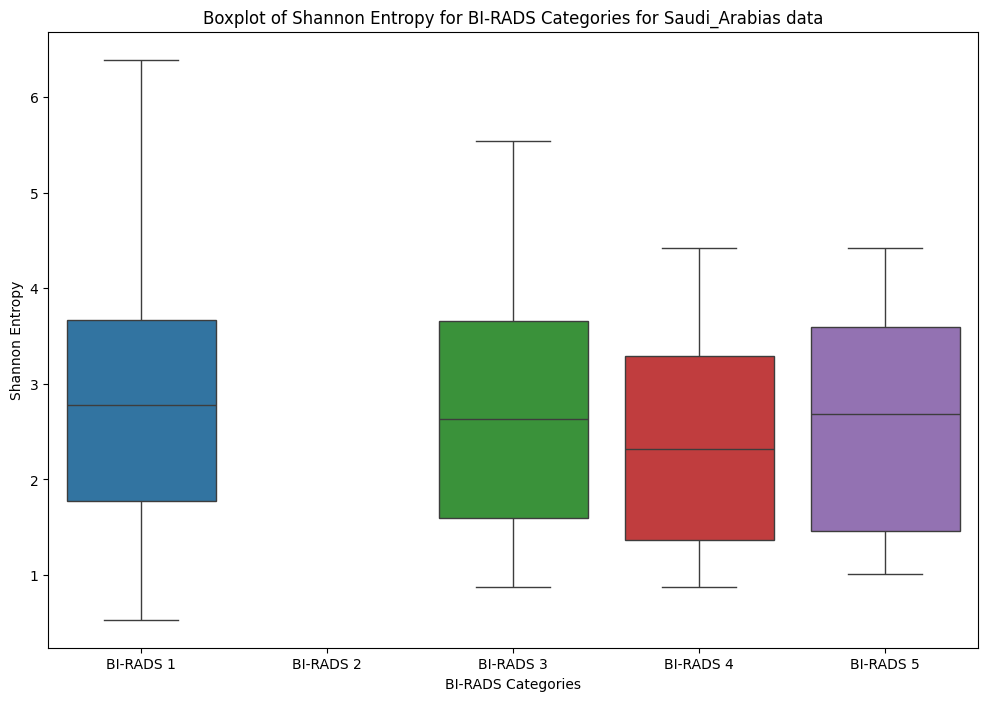

In [11]:
# Ndarja e klasave BI-RADS nga grupi Mammomat_Inspiration
Saudi_Arabias_data_br1_entropy = []
Saudi_Arabias_data_br2_entropy = []
Saudi_Arabias_data_br3_entropy = []
Saudi_Arabias_data_br4_entropy = []
Saudi_Arabias_data_br5_entropy = []


# Llogarit entropinë për secilën klasë BI-RADS
calculate_entropy(Saudi_Arabias_data_br1, Saudi_Arabias_data_br1_entropy)
calculate_entropy(Saudi_Arabias_data_br2, Saudi_Arabias_data_br2_entropy)
calculate_entropy(Saudi_Arabias_data_br3, Saudi_Arabias_data_br3_entropy)
calculate_entropy(Saudi_Arabias_data_br4, Saudi_Arabias_data_br4_entropy)
calculate_entropy(Saudi_Arabias_data_br5, Saudi_Arabias_data_br5_entropy)

# 3. Krijimi i një DataFrame për entropitë
data_dict = {
    'BI-RADS 1': Saudi_Arabias_data_br1_entropy,
    'BI-RADS 2': Saudi_Arabias_data_br2_entropy,
    'BI-RADS 3': Saudi_Arabias_data_br3_entropy,
    'BI-RADS 4': Saudi_Arabias_data_br4_entropy,
    'BI-RADS 5': Saudi_Arabias_data_br5_entropy
}

entropy_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

# 4. Ndërtimi i Boxplot-it për të krahasuar entropitë midis kategorive BI-RADS
plt.figure(figsize=(12, 8))
sns.boxplot(data=entropy_df)
plt.title('Boxplot of Shannon Entropy for BI-RADS Categories for Saudi_Arabias data')
plt.xlabel('BI-RADS Categories')
plt.ylabel('Shannon Entropy')
plt.show()

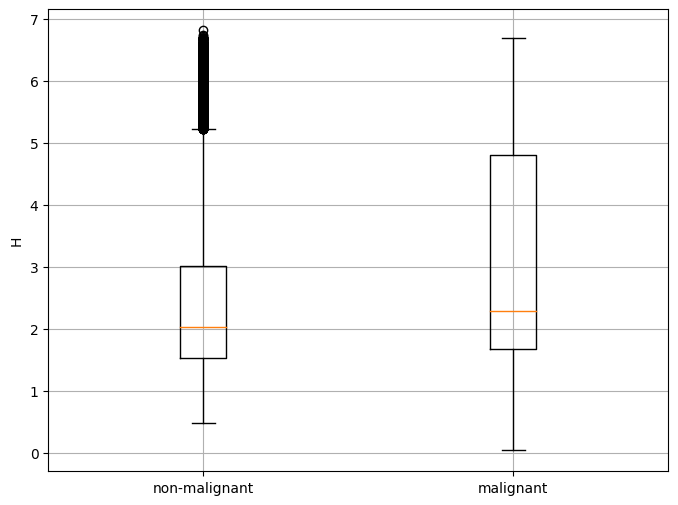

P-Value: 1.5541811640698218e-10
Ka një ndryshim domethënës midis dy grupeve.


In [16]:

entropy_classe_normal = np.concatenate([
    selected_columns_BLA_br1_entropy, 
    selected_columns_BLA_br2_entropy, 
    selected_columns_BLA_br3_entropy,
    Saudi_Arabias_data_br1_entropy,
    Saudi_Arabias_data_br2_entropy,
    Saudi_Arabias_data_br3_entropy
])

entropy_classe_malignant = np.concatenate([
    selected_columns_BLA_br4_entropy, 
    selected_columns_BLA_br5_entropy,
    Saudi_Arabias_data_br4_entropy,
    Saudi_Arabias_data_br5_entropy
])

# Boxplot për krahasim
plt.figure(figsize=(8, 6))
plt.boxplot([entropy_classe_normal, entropy_classe_malignant], labels=['non-malignant', 'malignant'])
plt.ylabel("H")
plt.grid(True)
plt.show()

# Llogaritja e p-value me Mann-Whitney U test 
stat, p_value = mannwhitneyu(entropy_classe_normal, entropy_classe_malignant, alternative='two-sided')

print(f"P-Value: {p_value}")

# Interpretimi
if p_value < 0.05:
    print("Ka një ndryshim domethënës midis dy grupeve.")
else:
    print("Nuk ka një ndryshim domethënës midis dy grupeve.")

In [15]:
image

NameError: name 'image' is not defined

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lexo imazhin në shkallë gri
img = cv2.imread('emri_i_imazhit.jpg', cv2.IMREAD_GRAYSCALE)

# Krijo një imazh bosh me të njëjtat përmasa
contour_image = np.zeros_like(img)

# Pika ose rajonet që dëshiron të analizosh (shembull: një listë koordinatash)
# Mund t’i ndërtosh ose zëvendësosh këto me mënyrën tënde të përzgjedhjes së rajoneve
points = [(100, 100), (150, 200), (50, 50)]

# Për çdo pikë, gjej zonën ku intensiteti është brenda ±2 nga vlera e pikselit në atë pikë
for (x, y) in points:
    center_val = img[y, x]
    lower = center_val - 2
    upper = center_val + 2

    # Maskë ku vlerat janë brenda ±2
    mask = cv2.inRange(img, lower, upper)

    # Gjej konturet (vijat e nivelit)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Vizato konturet në imazhin e ri me ngjyrë të bardhë
    cv2.drawContours(contour_image, contours, -1, (255), 1)

# Shfaq imazhin me konture
plt.figure(figsize=(10, 5))
plt.imshow(contour_image, cmap='gray')
plt.title('Vijat e Nivelit (±2)')
plt.axis('off')
plt.show()
